# Lesson 35 - Grid Search for Decision Trees

## Prepare Environment

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


spark = SparkSession.builder.getOrCreate()

## Hyperparameter Tuning for Decision Trees

Decision trees have two hyperparameters that we will typically want to tune. These are `maxDepth` and `minInstancesPerNode`. 

- The `maxDepth` hyperparameter specifies the maximum depth to which the tree is allowed to grow. Stated another way, this determines the maximum number of yes-or-no questions the tree is allowed to ask before generating a prediction. Low values tend to result in trees that are not deep enough to learn complicated patters in the data, but high values of this hyperparameter can lead to trees that severely overfit to the training data. 
- The `minInstancesPerNode` parameter is used to set a lower limit on the number of training observations allowed in the leaf nodes of the tree. Setting a high value for this hyperparameter prevent the tree from developing complicated rules that apply to only a few training observations, but setting it too high will result in trees that are not able to properly distinguish between observations that are unalike.

As we can see, there is a trade-off present in both of these hyperparameters. When creating a decision tree model, we are unlikely to know in advance what a good value would be for either of these hyperparameters. As a result, we will need to use grid search and cross-validation to tune these hyperparameters.

## Load and Explore Data

To denomstrate performing grid search for decision tree models, we will return to the [Diamonds dataset](https://ggplot2.tidyverse.org/reference/diamonds.html).

In [0]:
diamonds = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .schema(
        'carat DOUBLE, cut STRING, color STRING, clarity STRING, depth DOUBLE, '
        'table DOUBLE, price INTEGER, x DOUBLE, y DOUBLE, z DOUBLE'
    )
    .csv('/FileStore/tables/diamonds.txt')
)

diamonds.printSchema()

root
-- carat: double (nullable = true)
-- cut: string (nullable = true)
-- color: string (nullable = true)
-- clarity: string (nullable = true)
-- depth: double (nullable = true)
-- table: double (nullable = true)
-- price: integer (nullable = true)
-- x: double (nullable = true)
-- y: double (nullable = true)
-- z: double (nullable = true)

In [0]:
diamonds.show(10)

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
carat| cut|color|clarity|depth|table|price| x| y| z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
 0.23| Ideal| E| SI2| 61.5| 55.0| 326|3.95|3.98|2.43|
 0.21| Premium| E| SI1| 59.8| 61.0| 326|3.89|3.84|2.31|
 0.23| Good| E| VS1| 56.9| 65.0| 327|4.05|4.07|2.31|
 0.29| Premium| I| VS2| 62.4| 58.0| 334| 4.2|4.23|2.63|
 0.31| Good| J| SI2| 63.3| 58.0| 335|4.34|4.35|2.75|
 0.24|Very Good| J| VVS2| 62.8| 57.0| 336|3.94|3.96|2.48|
 0.24|Very Good| I| VVS1| 62.3| 57.0| 336|3.95|3.98|2.47|
 0.26|Very Good| H| SI1| 61.9| 55.0| 337|4.07|4.11|2.53|
 0.22| Fair| E| VS2| 65.1| 61.0| 337|3.87|3.78|2.49|
 0.23|Very Good| H| VS1| 59.4| 61.0| 338| 4.0|4.05|2.39|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
only showing top 10 rows

In [0]:
N = diamonds.count()
print(N)

53940

In [0]:
diamonds = diamonds.select('*', expr('LOG(carat) AS ln_carat'), expr('LOG(price) AS ln_price'))
diamonds.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+-------------------+------------------+
carat| cut|color|clarity|depth|table|price| x| y| z| ln_carat| ln_price|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-------------------+------------------+
 0.23| Ideal| E| SI2| 61.5| 55.0| 326|3.95|3.98|2.43|-1.4696759700589417| 5.786897381366708|
 0.21| Premium| E| SI1| 59.8| 61.0| 326|3.89|3.84|2.31|-1.5606477482646683| 5.786897381366708|
 0.23| Good| E| VS1| 56.9| 65.0| 327|4.05|4.07|2.31|-1.4696759700589417|5.7899601708972535|
 0.29| Premium| I| VS2| 62.4| 58.0| 334| 4.2|4.23|2.63|-1.2378743560016174| 5.8111409929767|
 0.31| Good| J| SI2| 63.3| 58.0| 335|4.34|4.35|2.75| -1.171182981502945| 5.814130531825066|
 0.24|Very Good| J| VVS2| 62.8| 57.0| 336|3.94|3.96|2.48|-1.4271163556401458| 5.817111159963204|
 0.24|Very Good| I| VVS1| 62.3| 57.0| 336|3.95|3.98|2.47|-1.4271163556401458| 5.817111159963204|
 0.26|Very Good| H| SI1| 61.9| 55.0| 337|4.07|4.11|2.53|-1.3470736479666092| 5.820082930352362|
 0.22| Fair| E| VS2| 65.1| 61.0| 337|3.87|3.78|2.49|-1.5141277326297755| 5.820082930352362|
 0.23|Very Good| H| VS1| 59.4| 61.0| 338| 4.0|4.05|2.39|-1.4696759700589417| 5.823045895483019|
 0.3| Good| J| SI1| 64.0| 55.0| 339|4.25|4.28|2.73|-1.2039728043259361| 5.82600010738045|
 0.23| Ideal| J| VS1| 62.8| 56.0| 340|3.93| 3.9|2.46|-1.4696759700589417|5.8289456176102075|
 0.22| Premium| F| SI1| 60.4| 61.0| 342|3.88|3.84|2.33|-1.5141277326297755| 5.834810737062605|
 0.31| Ideal| J| SI2| 62.2| 54.0| 344|4.35|4.37|2.71| -1.171182981502945| 5.840641657373398|
 0.2| Premium| E| SI2| 60.2| 62.0| 345|3.79|3.75|2.27|-1.6094379124341003| 5.84354441703136|
 0.32| Premium| E| I1| 60.9| 58.0| 345|4.38|4.42|2.68|-1.1394342831883648| 5.84354441703136|
 0.3| Ideal| I| SI2| 62.0| 54.0| 348|4.31|4.34|2.68|-1.2039728043259361|5.8522024797744745|
 0.3| Good| J| SI1| 63.4| 54.0| 351|4.23|4.29| 2.7|-1.2039728043259361| 5.860786223465865|
 0.3| Good| J| SI1| 63.8| 56.0| 351|4.23|4.26|2.71|-1.2039728043259361| 5.860786223465865|
 0.3|Very Good| J| SI1| 62.7| 59.0| 351|4.21|4.27|2.66|-1.2039728043259361| 5.860786223465865|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+-------------------+------------------+
only showing top 20 rows

### Distribution of Label Values

To serve as a baseline against which we can compare our model, we will check the distribution of the label values.

In [0]:
(
    diamonds
    .select('cut')
    .groupby('cut')
    .agg(
        expr('COUNT(*) as count'), 
        expr(f'ROUND(COUNT(*)/{N},4) as prop')
    )
    .show()
)

+---------+-----+------+
 cut|count| prop|
+---------+-----+------+
 Premium|13791|0.2557|
 Ideal|21551|0.3995|
 Good| 4906| 0.091|
 Fair| 1610|0.0298|
Very Good|12082| 0.224|
+---------+-----+------+

### Numerical and Categorical Features

We need to create lists specifying the names of our numerical features and our categorical features.

In [0]:
num_features = ['ln_carat', 'ln_price', 'x', 'y', 'z', 'depth', 'table']
cat_features = ['color', 'clarity']

features = num_features + cat_features

### Preprocessing Pipeline

We will now create stages to be used in a pre-processing pipeline. Recall that decision tree models do not require, and typically do not benefit from, one-hot encoding of categorical variables. We do still need to perform integer encoding on categorical variables.

In [0]:
ix_features = [c + '_ix' for c in cat_features]

label_indexer = StringIndexer(inputCol='cut', outputCol='label')

feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

assembler = VectorAssembler(inputCols=num_features + ix_features, outputCol='features')

In [0]:
preprocessor = Pipeline(stages=[label_indexer, feature_indexer, assembler]).fit(diamonds)
train = preprocessor.transform(diamonds)

train.select(['features']).show(10, truncate=False)

+-------------------------------------------------------------------------+
features |
+-------------------------------------------------------------------------+
[-1.4696759700589417,5.786897381366708,3.95,3.98,2.43,61.5,55.0,1.0,2.0] |
[-1.5606477482646683,5.786897381366708,3.89,3.84,2.31,59.8,61.0,1.0,0.0] |
[-1.4696759700589417,5.7899601708972535,4.05,4.07,2.31,56.9,65.0,1.0,3.0]|
[-1.2378743560016174,5.8111409929767,4.2,4.23,2.63,62.4,58.0,5.0,1.0] |
[-1.171182981502945,5.814130531825066,4.34,4.35,2.75,63.3,58.0,6.0,2.0] |
[-1.4271163556401458,5.817111159963204,3.94,3.96,2.48,62.8,57.0,6.0,4.0] |
[-1.4271163556401458,5.817111159963204,3.95,3.98,2.47,62.3,57.0,5.0,5.0] |
[-1.3470736479666092,5.820082930352362,4.07,4.11,2.53,61.9,55.0,3.0,0.0] |
[-1.5141277326297755,5.820082930352362,3.87,3.78,2.49,65.1,61.0,1.0,1.0] |
[-1.4696759700589417,5.823045895483019,4.0,4.05,2.39,59.4,61.0,3.0,3.0] |
+-------------------------------------------------------------------------+
only showing top 10 rows

### Evaluator

We will create an accuracy evaluator for use in scoring our models.

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

## Grid Seach for Decision Tree

We will now use `CrossValidator` to perform a grid search to tune the `maxDepth` and `minInstancesPerNode` hyperparameters.

In [0]:
dtree = DecisionTreeClassifier(featuresCol='features', labelCol='label', seed=1)

param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, range(4,26,2) )
              .addGrid(dtree.minInstancesPerNode, [4, 8, 16, 32, 64])
             ).build()

cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, numFolds=5, 
                    evaluator=accuracy_eval, seed=1, parallelism=6)

cv_model = cv.fit(train)

opt_model = cv_model.bestModel
opt_maxDepth = opt_model.getMaxDepth()
opt_minInstancesPerNode = opt_model.getMinInstancesPerNode()

print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Max CV Score: 0.7266
Optimal Depth: 20
Optimal MinInst: 32

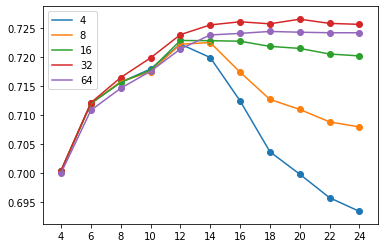

In [0]:
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list, columns=['maxDepth', 'minInst', 'acc'])

for en in cv_summary.minInst.unique():
    sel = cv_summary.minInst == en
    plt.plot( cv_summary.maxDepth[sel]  , cv_summary.acc[sel], label=en)
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])  
plt.legend()
plt.xticks(cv_summary.maxDepth[sel])
plt.show()

### Visualize the Tree

In [0]:
print(opt_model.toDebugString) # if you need to explain the rule, this is the structure of the tree.

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b6f4bc4ab231, depth=20, numNodes=691, numClasses=5, numFeatures=9
 If (feature 6 <= 57.05)
 If (feature 5 <= 63.05)
 If (feature 5 <= 62.75)
 If (feature 5 <= 60.25)
 If (feature 5 <= 58.650000000000006)
 Predict: 3.0
 Else (feature 5 > 58.650000000000006)
 If (feature 0 <= -1.2209235801637768)
 Predict: 2.0
 Else (feature 0 > -1.2209235801637768)
 If (feature 5 <= 59.95)
 If (feature 4 <= 2.7649999999999997)
 Predict: 0.0
 Else (feature 4 > 2.7649999999999997)
 If (feature 8 in {4.0,6.0})
 Predict: 2.0
 Else (feature 8 not in {4.0,6.0})
 If (feature 1 <= 7.447459819823974)
 Predict: 0.0
 Else (feature 1 > 7.447459819823974)
 If (feature 0 <= -0.34958262644275423)
 Predict: 2.0
 Else (feature 0 > -0.34958262644275423)
 If (feature 6 <= 56.05)
 If (feature 3 <= 6.455)
 Predict: 1.0
 Else (feature 3 > 6.455)
 If (feature 1 <= 8.913819269430384)
 Predict: 0.0
 Else (feature 1 > 8.913819269430384)
 Predict: 2.0
 Else (feature 6 > 56.05)
 If (feature 7 in {0.0,1.0,2.0,3.0})
 Predict: 0.0
 Else (feature 7 not in {0.0,1.0,2.0,3.0})
 Predict: 2.0
 Else (feature 5 > 59.95)
 If (feature 8 in {4.0,5.0,6.0})
 Predict: 0.0
 Else (feature 8 not in {4.0,5.0,6.0})
 If (feature 0 <= 0.09074393802268867)
 If (feature 0 <= -1.0643158929353038)
 Predict: 0.0
 Else (feature 0 > -1.0643158929353038)
 If (feature 1 <= 6.762151137867967)
 Predict: 2.0
 Else (feature 1 > 6.762151137867967)
 If (feature 4 <= 3.225)
 Predict: 0.0
 Else (feature 4 > 3.225)
 If (feature 2 <= 5.835)
 Predict: 2.0
 Else (feature 2 > 5.835)
 Predict: 0.0
 Else (feature 0 > 0.09074393802268867)
 Predict: 0.0
 Else (feature 5 > 60.25)
 If (feature 0 <= -1.2209235801637768)
 If (feature 1 <= 6.599189763913676)
 If (feature 8 in {0.0,1.0,2.0,3.0,6.0})
 If (feature 1 <= 6.158037187038744)
 If (feature 6 <= 55.05)
 Predict: 0.0
 Else (feature 6 > 55.05)
 If (feature 5 <= 61.849999999999994)
 Predict: 0.0
 Else (feature 5 > 61.849999999999994)
 Predict: 2.0
 Else (feature 1 > 6.158037187038744)
 Predict: 0.0
 Else (feature 8 not in {0.0,1.0,2.0,3.0,6.0})
 If (feature 1 <= 6.3144530238997145)
 If (feature 7 in {0.0,1.0,4.0,6.0})
 Predict: 2.0
 Else (feature 7 not in {0.0,1.0,4.0,6.0})
 If (feature 7 in {2.0,5.0})
 Predict: 0.0
 Else (feature 7 not in {2.0,5.0})
 Predict: 2.0
 Else (feature 1 > 6.3144530238997145)
 If (feature 7 in {0.0,1.0,3.0,4.0,5.0})
 Predict: 0.0
 Else (feature 7 not in {0.0,1.0,3.0,4.0,5.0})
 Predict: 2.0
 Else (feature 1 > 6.599189763913676)
 Predict: 0.0
 Else (feature 0 > -1.2209235801637768)
 If (feature 0 <= -0.3638693126647823)
 Predict: 0.0
 Else (feature 0 > -0.3638693126647823)
 If (feature 5 <= 62.349999999999994)
 If (feature 1 <= 7.763658838273792)
 If (feature 2 <= 5.675)
 Predict: 2.0
 Else (feature 2 > 5.675)
 Predict: 0.0
 Else (feature 1 > 7.763658838273792)
 Predict: 0.0
 Else (feature 5 > 62.349999999999994)
 If (feature 6 <= 55.05)
 Predict: 0.0
 Else (feature 6 > 55.05)
 If (feature 2 <= 6.385)
 If (feature 1 <= 8.47886805550128)
 If (feature 2 <= 5.675)
 If (feature 7 in {0.0,4.0,5.0,6.0})
 Predict: 0.0
 Else (feature 7 not in {0.0,4.0,5.0,6.0})
 Predict: 2.0
 Else (feature 2 > 5.675)
 Predict: 0.0
 Else (feature 1 > 8.47886805550128)
 Predict: 2.0
 Else (feature 2 > 6.385)
 If (feature 8 in {0.0,1.0,3.0,4.0,5.0,6.0})
 Predict: 0.0
 Else (feature 8 not in {0.0,1.0,3.0,4.0,5.0,6.0})
 If (feature 2 <= 7.095)
 Predict: 0.0
 Else (feature 2 > 7.095)
 If (feature 0 <= 0.7006161167420488)
 Predict: 1.0
 Else (feature 0 > 0.7006161167420488)
 Predict: 0.0
 Else (feature 5 > 62.75)
 If (feature 1 <= 6.599189763913676)
 If (feature 1 <= 6.3144530238997145)
 Predict: 2.0
 Else (feature 1 > 6.3144530238997145)
 If (feature 3 <= 4.385)
 If (feature 2 <= 4.335)
 Predict: 2.0
 Else (feature 2 > 4.335)
 Predict: 0.0
 Else (feature 3 > 4.385)
 Predict: 2.0
 Else (feature 1 > 6.599189763913676)
 If (feature 3 <= 4.695)
 Predict: 0.0
 Else (feature 3 > 4.695)
 If (feature 2 <= 6.385)
 If (feature 3

### Feature Importances

In [0]:
pd.DataFrame({
    'feature':features,
    'importance':opt_model.featureImportances
})

Out[14]:

,feature,importance
0,ln_carat,0.020983
1,ln_price,0.027709
2,x,0.033492
3,y,0.042028
4,z,0.004862
5,depth,0.372662
6,table,0.480283
7,color,0.009057
8,clarity,0.008925


## Evaluating Model

We will now use the `MulticlassMetrics` class to explore our model's performance on the training set.

In [0]:
train_pred = opt_model.transform(train)

In [0]:
train_pred = opt_model.transform(train)

pred_and_labels = train_pred.rdd.map(lambda x : (x['prediction'], x['label']) )
pred_and_labels.persist()

for item in pred_and_labels.take(5):
    print(item)
    

(0.0, 0.0)
(1.0, 1.0)
(3.0, 3.0)
(2.0, 1.0)
(3.0, 3.0)

### Accuracy

In [0]:
metrics = MulticlassMetrics(pred_and_labels)
print(metrics.accuracy)

0.7505005561735262

In [0]:
labels = preprocessor.stages[0].labels

In [0]:
cm = metrics.confusionMatrix().toArray().astype(int)

pd.DataFrame(
    data=cm, 
    columns=labels,
    index=labels
)


Out[19]:

,Ideal,Premium,Very Good,Good,Fair
Ideal,19847,837,813,37,17
Premium,1561,11004,1064,162,0
Very Good,2617,2948,5621,859,37
Good,81,486,1191,2813,335
Fair,14,61,60,278,1197


### Precision and Recall by Class

In [0]:
print('cut         Precision   Recall')
print('------------------------------')
for i, lab in enumerate(labels):
    print(f'{lab:<12}{metrics.precision(i):<12.4f}{metrics.recall(i):.4f}')
    

cut Precision Recall
------------------------------
Ideal 0.8228 0.9209
Premium 0.7175 0.7979
Very Good 0.6425 0.4652
Good 0.6780 0.5734
Fair 0.7547 0.7435

Keep entire dataset, do cv, identify the optimal model;
split 80-20 training and validation, refit final model on the 80, and validate on the 20


Another approach. cv prediction
do cv, identify final model
another round of cv, without grid search. train on the 4 folds, and predit